# Parth Rege - Reinforcement Learning 

**EN.685.801.21.SP24**

**Professors Rodriguez, Saeed, Johnson**

<a id="contents"></a>
# Contents

1. [Load Data](#step1) <br>
2. [Generate Features](#step2) <br>
3. [Q-Learning Algorithm](#step3) <br>
4. [Deep Q-Learning Algorithm](#step4) <br>
    &nbsp;&nbsp;&nbsp;&nbsp;4.1 [DQN with Policy and Target Network](#step41)<br>
    &nbsp;&nbsp;&nbsp;&nbsp;4.2 [DQN with Policy Network Only](#step42)<br>
    &nbsp;&nbsp;&nbsp;&nbsp;4.3 [DQN with Policy Network Only But No Replay](#step43)<br>
    &nbsp;&nbsp;&nbsp;&nbsp;4.4 [DQN with Policy Network and Regularization](#step44)<br>
    &nbsp;&nbsp;&nbsp;&nbsp;4.5 [DQN with Policy and Target Network and Regularization](#step45)<br>
5. [Future Considerations](#step5) <br>

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
import random
import plotly.graph_objects as go
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()

from keras.models import Sequential
from keras.regularizers import l2
from keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from keras.layers import LSTM, Dense
from keras.models import Sequential, clone_model
from sklearn.preprocessing import MinMaxScaler
import GPUtil

In [16]:

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        print("GPU found:", gpu)
else:
    print("No GPU found")

gpus = GPUtil.getGPUs()
if gpus:
    for gpu in gpus:
        print(f"GPU {gpu.id}: {gpu.name} with {gpu.memoryTotal}MB memory")
else:
    print("No GPU found")


Num GPUs Available:  1
GPU found: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
GPU 0: NVIDIA GeForce RTX 4070 Laptop GPU with 8188.0MB memory


## 1 <a id="step1">(Load Data) Load 3 years of AAPL data pulled from NASDAQ w/ Sentiment</a>
<a href="#contents">^ Contents</a>

In our previous module submission, we detailed the creation of the sentiment included dataset for AAPL stock price data. To simplify ETL, I will be utilizing that data as the starting point for this module submission. The process here will be:

1. Load and prep AAPL daily sentiment dataset from earlier module submission
2. Filter daily AAPL data for year in which you want to conduct RL analysis simulation. I will be using 2023 for this.
3. Load filter and join Fed rate (TBill Avg Rate) data by Quarter. 

Reference data is sourced from: https://fiscaldata.treasury.gov/datasets/average-interest-rates-treasury-securities/average-interest-rates-on-u-s-treasury-securities

In [6]:
# load data
sent = pd.read_csv('sentiment_aapl.csv')

sent['Close/Last'] = pd.to_numeric(sent['Close/Last'].str.replace('$', ''), errors='coerce')
sent['Open'] = pd.to_numeric(sent['Open'].str.replace('$', ''), errors='coerce')
sent['High'] = pd.to_numeric(sent['High'].str.replace('$', ''), errors='coerce')
sent['Low'] = pd.to_numeric(sent['Low'].str.replace('$', ''), errors='coerce')

# sort by date
sent['Date'] = pd.to_datetime(sent['Date'])
sent = sent.sort_values('Date')
sent.reset_index(drop=True, inplace=True)

sent.info()
display(sent)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 795 entries, 0 to 794
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        795 non-null    datetime64[ns]
 1   Close/Last  795 non-null    float64       
 2   Volume      795 non-null    int64         
 3   Open        795 non-null    float64       
 4   High        795 non-null    float64       
 5   Low         795 non-null    float64       
 6   count       794 non-null    float64       
 7   normalized  794 non-null    float64       
 8   symbol      794 non-null    object        
dtypes: datetime64[ns](1), float64(6), int64(1), object(1)
memory usage: 56.0+ KB


,Date,Close/Last,Volume,Open,High,Low,count,normalized,symbol
0,2021-01-04,129.41,143301900,133.52,133.6116,126.760,2.0,0.9630,AAPL.US
1,2021-01-05,131.01,97664900,128.89,131.7400,128.430,6.0,0.8213,AAPL.US
2,2021-01-06,126.60,155088000,127.72,131.0499,126.382,2.0,0.9060,AAPL.US
3,2021-01-07,130.92,109578200,128.36,131.6300,127.860,3.0,0.5427,AAPL.US
4,2021-01-08,132.05,105158200,132.43,132.6300,130.230,8.0,0.9473,AAPL.US
...,...,...,...,...,...,...,...,...,...
790,2024-02-26,181.16,40867420,182.24,182.7600,180.650,25.0,0.7475,AAPL.US
791,2024-02-27,182.63,54318850,181.10,183.9225,179.560,21.0,0.6107,AAPL.US
792,2024-02-28,181.42,48953940,182.51,183.1200,180.130,24.0,0.7662,AAPL.US
793,2024-02-29,180.75,136682600,181.27,182.5700,179.530,18.0,0.6934,AAPL.US


In [7]:
# filter for dates to merge
data = sent[(sent['Date'] >= '2023-01-01') & (sent['Date'] <= '2023-12-31')]
data.reset_index(drop=True, inplace=True)
display(data)

,Date,Close/Last,Volume,Open,High,Low,count,normalized,symbol
0,2023-01-03,125.07,112117500,130.280,130.9000,124.170,40.0,0.1977,AAPL.US
1,2023-01-04,126.36,89113630,126.890,128.6557,125.080,42.0,0.1409,AAPL.US
2,2023-01-05,125.02,80962710,127.130,127.7700,124.760,25.0,0.3639,AAPL.US
3,2023-01-06,129.62,87754720,126.010,130.2900,124.890,20.0,0.6063,AAPL.US
4,2023-01-09,130.15,70790810,130.465,133.4100,129.890,33.0,0.3944,AAPL.US
...,...,...,...,...,...,...,...,...,...
245,2023-12-22,193.60,37149570,195.180,195.4100,192.970,19.0,0.5320,AAPL.US
246,2023-12-26,193.05,28919310,193.610,193.8900,192.830,32.0,0.1969,AAPL.US
247,2023-12-27,193.15,48087680,192.490,193.5000,191.090,42.0,0.1106,AAPL.US
248,2023-12-28,193.58,34049900,194.140,194.6600,193.170,36.0,0.4137,AAPL.US


In [8]:
# load fed rate data
tbill = pd.read_csv('tbill_rates.csv')

# filter for tbill rate
tbill = tbill[tbill['Security Description'] == 'Treasury Bills']
tbill.reset_index(drop=True, inplace=True)

tbill.info()
display(tbill)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Record Date                   120 non-null    object 
 1   Security Type Description     120 non-null    object 
 2   Security Description          120 non-null    object 
 3   Average Interest Rate Amount  120 non-null    float64
 4   Source Line Number            120 non-null    int64  
 5   Fiscal Year                   120 non-null    int64  
 6   Fiscal Quarter Number         120 non-null    int64  
 7   Calendar Year                 120 non-null    int64  
 8   Calendar Quarter Number       120 non-null    int64  
 9   Calendar Month Number         120 non-null    int64  
 10  Calendar Day Number           120 non-null    int64  
dtypes: float64(1), int64(7), object(3)
memory usage: 10.4+ KB


,Record Date,Security Type Description,Security Description,Average Interest Rate Amount,Source Line Number,Fiscal Year,Fiscal Quarter Number,Calendar Year,Calendar Quarter Number,Calendar Month Number,Calendar Day Number
0,2/29/2024,Marketable,Treasury Bills,5.384,1,2024,2,2024,1,2,29
1,1/31/2024,Marketable,Treasury Bills,5.411,1,2024,2,2024,1,1,31
2,12/31/2023,Marketable,Treasury Bills,5.437,1,2024,1,2023,4,12,31
3,11/30/2023,Marketable,Treasury Bills,5.451,1,2024,1,2023,4,11,30
4,10/31/2023,Marketable,Treasury Bills,5.437,1,2024,1,2023,4,10,31
...,...,...,...,...,...,...,...,...,...,...,...
115,7/31/2014,Marketable,Treasury Bills,0.066,1,2014,4,2014,3,7,31
116,6/30/2014,Marketable,Treasury Bills,0.068,1,2014,3,2014,2,6,30
117,5/31/2014,Marketable,Treasury Bills,0.072,1,2014,3,2014,2,5,31
118,4/30/2014,Marketable,Treasury Bills,0.080,1,2014,3,2014,2,4,30


In [9]:
# create month-year column for easy merging
data['Month-Year'] = pd.to_datetime(data['Date']).dt.to_period('M').astype(str)
tbill['Month-Year'] = pd.to_datetime(tbill['Record Date']).dt.to_period('M').astype(str)

# left join tbill data
final_data = pd.merge(data, tbill[['Month-Year', 'Average Interest Rate Amount']], 
                       on='Month-Year', how='left')

display(final_data)

,Date,Close/Last,Volume,Open,High,Low,count,normalized,symbol,Month-Year,Average Interest Rate Amount
0,2023-01-03,125.07,112117500,130.280,130.9000,124.170,40.0,0.1977,AAPL.US,2023-01,4.242
1,2023-01-04,126.36,89113630,126.890,128.6557,125.080,42.0,0.1409,AAPL.US,2023-01,4.242
2,2023-01-05,125.02,80962710,127.130,127.7700,124.760,25.0,0.3639,AAPL.US,2023-01,4.242
3,2023-01-06,129.62,87754720,126.010,130.2900,124.890,20.0,0.6063,AAPL.US,2023-01,4.242
4,2023-01-09,130.15,70790810,130.465,133.4100,129.890,33.0,0.3944,AAPL.US,2023-01,4.242
...,...,...,...,...,...,...,...,...,...,...,...
245,2023-12-22,193.60,37149570,195.180,195.4100,192.970,19.0,0.5320,AAPL.US,2023-12,5.437
246,2023-12-26,193.05,28919310,193.610,193.8900,192.830,32.0,0.1969,AAPL.US,2023-12,5.437
247,2023-12-27,193.15,48087680,192.490,193.5000,191.090,42.0,0.1106,AAPL.US,2023-12,5.437
248,2023-12-28,193.58,34049900,194.140,194.6600,193.170,36.0,0.4137,AAPL.US,2023-12,5.437


Now that we have our sourced features, we will move onto the next section in order to generate features to help feed our eventual RL algorithms.

## 2 <a id="step2">(Generate Features) Feature Engineering and LSTM Implementation</a>
<a href="#contents">^ Contents</a>

We will now create lagged features for close price and sentiment while also creating a delta fed rate column to capture the month-over-month change in fed rate (*this will be to help train the RL agent to make policy based on changing fed rate*).

In [10]:
# pull base feature columns
close_series = final_data['Close/Last']
sentiment_series = final_data['normalized']
tbill_series = final_data['Average Interest Rate Amount']

# generate lag features for close price
lagged_close_10 = close_series.shift(-10)
lagged_close_9 = close_series.shift(-9)
lagged_close_8 = close_series.shift(-8)
lagged_close_7 = close_series.shift(-7)
lagged_close_6 = close_series.shift(-6)
lagged_close_5 = close_series.shift(-5)
lagged_close_4 = close_series.shift(-4)
lagged_close_3 = close_series.shift(-3)
lagged_close_2 = close_series.shift(-2)
lagged_close_1 = close_series.shift(-1)

# generate lag features for sentiment
lagged_sentiment_10 = sentiment_series.shift(-10)
lagged_sentiment_9 = sentiment_series.shift(-9)
lagged_sentiment_8 = sentiment_series.shift(-8)
lagged_sentiment_7 = sentiment_series.shift(-7)
lagged_sentiment_6 = sentiment_series.shift(-6)
lagged_sentiment_5 = sentiment_series.shift(-5)
lagged_sentiment_4 = sentiment_series.shift(-4)
lagged_sentiment_3 = sentiment_series.shift(-3)
lagged_sentiment_2 = sentiment_series.shift(-2)
lagged_sentiment_1 = sentiment_series.shift(-1)

# generate MoM delta feature for fed rate
delta_tbill_30 = tbill_series - tbill_series.shift(-30)


# combine into df
lagged_df = pd.DataFrame({'Close': close_series, 
                          'Close_Lagged_10': lagged_close_10,
                          'Close_Lagged_9': lagged_close_9,
                          'Close_Lagged_8': lagged_close_8,
                          'Close_Lagged_7': lagged_close_7,
                          'Close_Lagged_6': lagged_close_6,
                          'Close_Lagged_5': lagged_close_5,
                          'Close_Lagged_4': lagged_close_4, 
                          'Close_Lagged_3': lagged_close_3, 
                          'Close_Lagged_2': lagged_close_2, 
                          'Close_Lagged_1': lagged_close_1, 
                          'Sentiment': sentiment_series,
                          'Sent_Lagged_10': lagged_sentiment_10,
                          'Sent_Lagged_9': lagged_sentiment_9,
                          'Sent_Lagged_8': lagged_sentiment_8,
                          'Sent_Lagged_7': lagged_sentiment_7,
                          'Sent_Lagged_6': lagged_sentiment_6,
                          'Sent_Lagged_5': lagged_sentiment_5,
                          'Sent_Lagged_4': lagged_sentiment_4,
                          'Sent_Lagged_3': lagged_sentiment_3,
                          'Sent_Lagged_2': lagged_sentiment_2,
                          'Sent_Lagged_1': lagged_sentiment_1,
                          'TBill_Delta_30': delta_tbill_30})

# drop NaNs, reset index
lagged_df.dropna(inplace=True)
lagged_df.reset_index(drop=True, inplace=True)
lagged_df

,Close,Close_Lagged_10,Close_Lagged_9,Close_Lagged_8,Close_Lagged_7,Close_Lagged_6,Close_Lagged_5,Close_Lagged_4,Close_Lagged_3,Close_Lagged_2,...,Sent_Lagged_9,Sent_Lagged_8,Sent_Lagged_7,Sent_Lagged_6,Sent_Lagged_5,Sent_Lagged_4,Sent_Lagged_3,Sent_Lagged_2,Sent_Lagged_1,TBill_Delta_30
0,125.07,135.21,135.94,134.76,133.41,133.49,130.73,130.15,129.62,125.02,...,0.5684,0.3790,0.3819,0.3867,0.4647,0.3944,0.6063,0.3639,0.1409,-0.233
1,126.36,135.27,135.21,135.94,134.76,133.41,133.49,130.73,130.15,129.62,...,0.2436,0.5684,0.3790,0.3819,0.3867,0.4647,0.3944,0.6063,0.3639,-0.233
2,125.02,137.87,135.27,135.21,135.94,134.76,133.41,133.49,130.73,130.15,...,0.7244,0.2436,0.5684,0.3790,0.3819,0.3867,0.4647,0.3944,0.6063,-0.233
3,129.62,141.11,137.87,135.27,135.21,135.94,134.76,133.41,133.49,130.73,...,0.3608,0.7244,0.2436,0.5684,0.3790,0.3819,0.3867,0.4647,0.3944,-0.233
4,130.15,142.53,141.11,137.87,135.27,135.21,135.94,134.76,133.41,133.49,...,0.5641,0.3608,0.7244,0.2436,0.5684,0.3790,0.3819,0.3867,0.4647,-0.233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,182.41,189.97,191.31,190.64,191.45,189.69,189.71,188.01,187.44,184.80,...,0.5859,0.4360,0.1307,0.5721,0.7326,0.7577,0.6527,0.5723,0.5566,0.014
216,186.40,189.79,189.97,191.31,190.64,191.45,189.69,189.71,188.01,187.44,...,0.6564,0.5859,0.4360,0.1307,0.5721,0.7326,0.7577,0.6527,0.5723,0.014
217,184.80,190.40,189.79,189.97,191.31,190.64,191.45,189.69,189.71,188.01,...,0.7044,0.6564,0.5859,0.4360,0.1307,0.5721,0.7326,0.7577,0.6527,0.014
218,187.44,189.37,190.40,189.79,189.97,191.31,190.64,191.45,189.69,189.71,...,0.6914,0.7044,0.6564,0.5859,0.4360,0.1307,0.5721,0.7326,0.7577,0.014


Now that we have the base data, let us utilize an LSTM to include a forecasted next-day price for each state as an additional feature.

In [11]:
# lookback
num_prev_days = 10

# prepare input data for LSTM
X = []
y = []

for i in range(len(lagged_df) - num_prev_days):
    X.append(lagged_df[['Close', 'Sentiment', 'TBill_Delta_30']].iloc[i:i+num_prev_days].values)
    y.append(lagged_df['Close'].iloc[i + num_prev_days])

X = np.array(X)
y = np.array(y)

# normalize for LSTM training
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# reshape for input into LSTM
X_reshaped = X_scaled.reshape(X_scaled.shape[0], num_prev_days, X_scaled.shape[2])

# LSTM architecture
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(num_prev_days, X_scaled.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# train LSTM
model.fit(X_reshaped, y_scaled, epochs=100, batch_size=32, verbose=0)

# predict and inverse transform predictions
predicted_values_scaled = model.predict(X_reshaped)
predicted_values = scaler_y.inverse_transform(predicted_values_scaled)

# pad predictions with lookback + 1 so that every row shows predicted value next day
padded_pred = np.concatenate((np.full((num_prev_days - 1, 1), np.nan), predicted_values, np.full((1, 1), np.nan)))
len(padded_pred)

# insert data into dataframe
lagged_df.insert(1, 'Pred_Close_Tmrw', padded_pred)
lagged_df = lagged_df.iloc[:-1]
lagged_df

,Close,Pred_Close_Tmrw,Close_Lagged_10,Close_Lagged_9,Close_Lagged_8,Close_Lagged_7,Close_Lagged_6,Close_Lagged_5,Close_Lagged_4,Close_Lagged_3,...,Sent_Lagged_9,Sent_Lagged_8,Sent_Lagged_7,Sent_Lagged_6,Sent_Lagged_5,Sent_Lagged_4,Sent_Lagged_3,Sent_Lagged_2,Sent_Lagged_1,TBill_Delta_30
0,125.07,NaN,135.21,135.94,134.76,133.41,133.49,130.73,130.15,129.62,...,0.5684,0.3790,0.3819,0.3867,0.4647,0.3944,0.6063,0.3639,0.1409,-0.233
1,126.36,NaN,135.27,135.21,135.94,134.76,133.41,133.49,130.73,130.15,...,0.2436,0.5684,0.3790,0.3819,0.3867,0.4647,0.3944,0.6063,0.3639,-0.233
2,125.02,NaN,137.87,135.27,135.21,135.94,134.76,133.41,133.49,130.73,...,0.7244,0.2436,0.5684,0.3790,0.3819,0.3867,0.4647,0.3944,0.6063,-0.233
3,129.62,NaN,141.11,137.87,135.27,135.21,135.94,134.76,133.41,133.49,...,0.3608,0.7244,0.2436,0.5684,0.3790,0.3819,0.3867,0.4647,0.3944,-0.233
4,130.15,NaN,142.53,141.11,137.87,135.27,135.21,135.94,134.76,133.41,...,0.5641,0.3608,0.7244,0.2436,0.5684,0.3790,0.3819,0.3867,0.4647,-0.233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,182.89,183.867783,191.31,190.64,191.45,189.69,189.71,188.01,187.44,184.80,...,0.4360,0.1307,0.5721,0.7326,0.7577,0.6527,0.5723,0.5566,0.4812,0.014
215,182.41,185.484467,189.97,191.31,190.64,191.45,189.69,189.71,188.01,187.44,...,0.5859,0.4360,0.1307,0.5721,0.7326,0.7577,0.6527,0.5723,0.5566,0.014
216,186.40,187.363861,189.79,189.97,191.31,190.64,191.45,189.69,189.71,188.01,...,0.6564,0.5859,0.4360,0.1307,0.5721,0.7326,0.7577,0.6527,0.5723,0.014
217,184.80,188.510544,190.40,189.79,189.97,191.31,190.64,191.45,189.69,189.71,...,0.7044,0.6564,0.5859,0.4360,0.1307,0.5721,0.7326,0.7577,0.6527,0.014


Now let's just remove NaNs so that the RL agent is not training using a NaN.

In [12]:
# drop off all NaNs and continue with shortened dataset
lagged_df = lagged_df.iloc[9:]
lagged_df.reset_index(drop=True, inplace=True)
lagged_df

,Close,Pred_Close_Tmrw,Close_Lagged_10,Close_Lagged_9,Close_Lagged_8,Close_Lagged_7,Close_Lagged_6,Close_Lagged_5,Close_Lagged_4,Close_Lagged_3,...,Sent_Lagged_9,Sent_Lagged_8,Sent_Lagged_7,Sent_Lagged_6,Sent_Lagged_5,Sent_Lagged_4,Sent_Lagged_3,Sent_Lagged_2,Sent_Lagged_1,TBill_Delta_30
0,135.94,136.455338,144.29,143.00,145.93,143.96,141.86,142.53,141.11,137.87,...,0.3511,0.3045,0.5189,0.4301,0.6312,0.5641,0.3608,0.7244,0.2436,-0.392
1,135.21,137.346298,145.43,144.29,143.00,145.93,143.96,141.86,142.53,141.11,...,0.3100,0.3511,0.3045,0.5189,0.4301,0.6312,0.5641,0.3608,0.7244,-0.392
2,135.27,138.239349,150.82,145.43,144.29,143.00,145.93,143.96,141.86,142.53,...,0.5118,0.3100,0.3511,0.3045,0.5189,0.4301,0.6312,0.5641,0.3608,-0.392
3,137.87,138.981003,154.50,150.82,145.43,144.29,143.00,145.93,143.96,141.86,...,0.3336,0.5118,0.3100,0.3511,0.3045,0.5189,0.4301,0.6312,0.5641,-0.392
4,141.11,139.735794,151.73,154.50,150.82,145.43,144.29,143.00,145.93,143.96,...,0.2549,0.3336,0.5118,0.3100,0.3511,0.3045,0.5189,0.4301,0.6312,-0.392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,182.89,183.867783,191.31,190.64,191.45,189.69,189.71,188.01,187.44,184.80,...,0.4360,0.1307,0.5721,0.7326,0.7577,0.6527,0.5723,0.5566,0.4812,0.014
206,182.41,185.484467,189.97,191.31,190.64,191.45,189.69,189.71,188.01,187.44,...,0.5859,0.4360,0.1307,0.5721,0.7326,0.7577,0.6527,0.5723,0.5566,0.014
207,186.40,187.363861,189.79,189.97,191.31,190.64,191.45,189.69,189.71,188.01,...,0.6564,0.5859,0.4360,0.1307,0.5721,0.7326,0.7577,0.6527,0.5723,0.014
208,184.80,188.510544,190.40,189.79,189.97,191.31,190.64,191.45,189.69,189.71,...,0.7044,0.6564,0.5859,0.4360,0.1307,0.5721,0.7326,0.7577,0.6527,0.014


Let's also quickly just look at these predictions versus the real close prices. *Please note that there will be a bit of a forward shift in the data given that we are specifically trying to give each day's close price a peak into the future by giving it tomorrow's predicted close price thus the plot will look slightly shifted*.

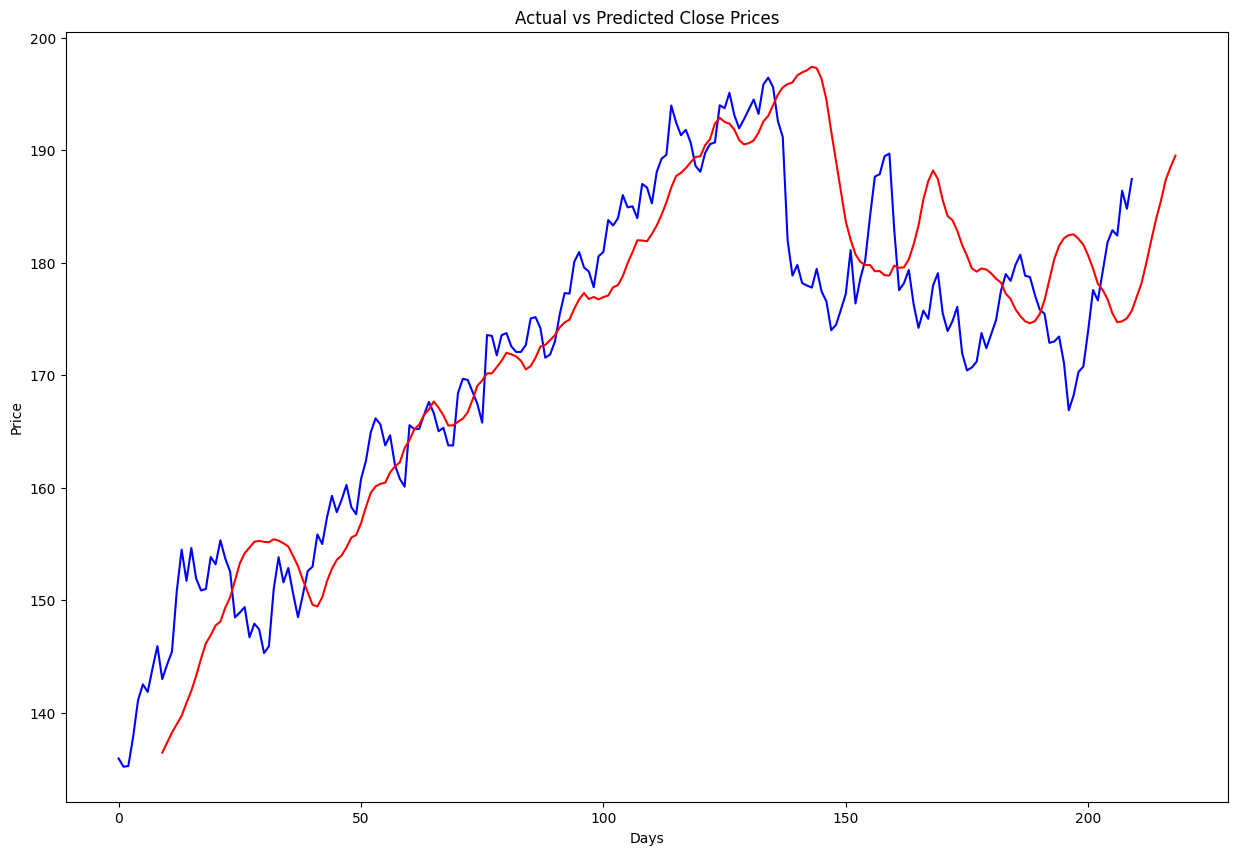

In [13]:
plt.figure(figsize=(15, 10))

# plot actual close prices
plt.plot(lagged_df['Close'], label='Actual Close Prices', color='blue')

# slot padded predicted values
plt.plot(padded_pred, label='Predicted Close Prices', color='red')

# set labels and title
plt.xlabel('Days')
plt.ylabel('Price')
plt.title('Actual vs Predicted Close Prices')
plt.show()

Now that we have completed sourcing, loading, preparing, cleaning the data while also generating relevant features, this dataframe can now be used to train a Q-Learning and Deep Q-Learning algorithm.

## 3 <a id="step3">(Q-Learning Algorithm) Implement a Simple Q-Learning Agent and Evaluate Performance</a>
<a href="#contents">^ Contents</a>

To understand how this is set up, we will do the following:
1. action - chosen by random exploring at the beginning of the episode, then policy based exploiting later on in the episodes.
2. Updating of Q-table will work through utilization of the Bellman equation to create a consistently optimized Q-table to help the RL agent makes action decisions.
3. reward will be calculated one of two ways (1) simple method of reward at each time is the portfolio value given the price the stock was bought at and (2) the complicated method which gives a side reward of profit or loss depending on the action made yesterday ***Note: the simple method was not stable so I switched to method 2***
4. The RL is then trained on 50,000 episodes, where in each episode it will run through the entire years worth of states (close price, sentiment, fed rate, forecasted values, etc.) and make decisions based on actions.
5. We will then plot out the portfolio value and reward value until it converges.

In [19]:
class QLearningAgent:
    
    def __init__(self, state_size, action_size, learning_rate=0.1, discount_factor=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.5):
        self.state_size = state_size
        self.action_size = action_size
        self.q_table = np.zeros((state_size, len(action_size)))
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

    # choose action using epsilon greedy 
    def choose_action(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size) # EXPLORE
        else:
            return np.argmax(self.q_table[state]) # EXPLOIT

    # update q-table using Bellman
    def update_q_table(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.discount_factor * self.q_table[next_state, best_next_action]
        td_error = td_target - self.q_table[state, action]
        self.q_table[state, action] += self.learning_rate * td_error

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
                       
    # save and load tables just for testing not needed
    def save_q_table(self, file_path):
        np.save(file_path, self.q_table)

    def load_q_table(self, file_path):
        if os.path.exists(file_path):
            self.q_table = np.load(file_path)
            
# calculate reward as profit based on today vs tmrw stock profits
def calculate_reward_old1(prev_action, current_price, prev_price):
    if prev_action == 0:  # Buy
        if current_price > prev_price:  # price went up after buying GOOD
            reward = round((current_price - prev_price), 2)  # reward is today's price - yesterday's price
        else:  # price went down after selling BAD
            reward = round((current_price - prev_price), 2)  # reward is today's price - yesterday's price
            
    elif prev_action == 1:  # Sell
        if current_price < prev_price:  # price went down after selling GOOD
            reward = round((prev_price - current_price), 2)  # reward is yesterday's price - today's price
        else:  # price went up after selling BAD
            reward = round((prev_price - current_price), 2)  # reward is yesterday's price - today's price
            
    else:
        reward = 0  # no action
    
    return reward

# calculate reward which rewards buying low and selling high but updates above with no negative rewards, just 0
def calculate_reward(prev_action, prev_price, current_price, num_stocks_held):
    if prev_action == 0:  # Buy
        reward = max(0, current_price - prev_price)  # potential profit
    
    elif prev_action == 1:  # Sell
        reward = max(0, prev_price - current_price)  # loss avoidance
    
    else:
        reward = 0  # Hold

    # additional reward for overall portfolio increase
    if num_stocks_held > 0:
        reward += (current_price - prev_price) * num_stocks_held
    
    return round(reward, 2)

def train_q_learning(state_matrix, action_space, num_episodes, max_budget, q_table_file='q_table.npy'):
    
    # initialize Q-learning agent
    agent = QLearningAgent(state_size=state_matrix.shape[0], action_size=action_space)
    profits = []
    rewards = []

    for episode in range(num_episodes):
        total_reward = 0
        num_stocks_held = 0
        available_budget = max_budget
        state = 0  # initial state

        episode_profit = []  # list to store profit/loss of each action in the episode
        buys = 0  # count of buy actions
        sells = 0  # count of sell actions
        
        prev_action = None

        for t in range(len(state_matrix) - 1):  # iterate over each time step
            
            # update action space based on the number of stocks held
            if available_budget < state_matrix[t, 0]:  # if budget is insufficient for buying
                modified_action_space = np.delete(action_space, 0)  # remove 'buy' action
            elif num_stocks_held == 0:
                modified_action_space = np.delete(action_space, 1)  # remove 'sell' action
            else:
                modified_action_space = action_space  # all actions are available
       
            action = agent.choose_action(state)
            
            # calculate the reward based on yesterday's chosen action
            reward = calculate_reward(prev_action, state_matrix[t-1, 0], state_matrix[t, 0], num_stocks_held)
            total_reward += reward
            
            value = 0

            # Calculate value based on action
            if action == 0 and available_budget >= state_matrix[t, 0]:  # Buy
                value = state_matrix[t, 0]  # value of purchased stock on day of purchase
                num_stocks_held += 1
                available_budget -= value
                buys += 1
                
            elif action == 1 and num_stocks_held > 0:  # Sell
                value = state_matrix[t, 0]  # value of sold stock on day of sale
                num_stocks_held -= 1
                available_budget += value
                sells += 1

            # update episode profit
            episode_profit.append(reward)        
            
            next_state = state + 1

            # update q-table
            agent.update_q_table(state, action, reward, next_state)

            # update previous action
            prev_action = action
            
            state = next_state

        # estimate total value by adjusting for the last action
        portfolio_value = available_budget + (num_stocks_held * state_matrix[-1, 0])
        
        if episode % 100 == 0:
            print(f"-------------------------------------------------------------------------------------------------------------------")
            print(f"Episode {episode + 1}, # Stocks: {num_stocks_held}, Total Rewards: {total_reward:.2f}, Portfolio Value: {portfolio_value:.2f}, Available Budget: {available_budget:.2f}, Buys: {buys}, Sells: {sells}")
            print(f"-------------------------------------------------------------------------------------------------------------------")
            print("Daily Profits:", episode_profit)
            agent.save_q_table(q_table_file)
        profits.append(portfolio_value)
        rewards.append(total_reward)

    return agent, profits, rewards

In [20]:
agent1, profits1, rewards1 = train_q_learning(lagged_df.values, action_space=[0, 1, 2],
                                  num_episodes=3000, max_budget=1000, q_table_file='q_table.npy')

-------------------------------------------------------------------------------------------------------------------
Episode 1, # Stocks: 6, Total Rewards: 309.62, Portfolio Value: 1201.93, Available Budget: 77.29, Buys: 49, Sells: 43
-------------------------------------------------------------------------------------------------------------------
Daily Profits: [0, 0.73, 0.12, 0, 6.48, 0, 0, 0, 0, 0, 2.58, 1.14, 16.17, 7.36, 0.0, 0, -2.73, 1.05, 0.28, 2.84, -1.3, 8.52, -6.48, -5.8, -12.21, 1.29, 0.98, -8.07, 3.63, -1.53, -8.4, 3.6, 35.84, 19.6, -13.38, 8.89, -13.68, -12.54, 13.79, 10.6, 2.8, 14.3, -5.1, 14.4, 9.4, -4.35, 3.3, 6.6, -9.85, -3.15, 15.6, 6.36, 15.24, 6.35, -3.24, -11.22, 5.4, -15.78, -7.38, -4.2, 27.3, -2.1, 0.1, 4.96, 6.96, -2.94, -8.15, 1.24, -7.8, -0.06, 32.55, 7.62, -0.54, -6.3, -6.54, -6.64, 38.9, -0.42, -10.38, 12.49, 1.17, -7.08, -3.0, 0.0, 4.34, 14.16, 0.66, -5.76, -10.56, 1.4, 8.05, 17.08, 11.22, -0.3, 17.04, 6.02, -5.48, -2.22, -8.34, 13.75, 2.73, 19.81, -2.88, 

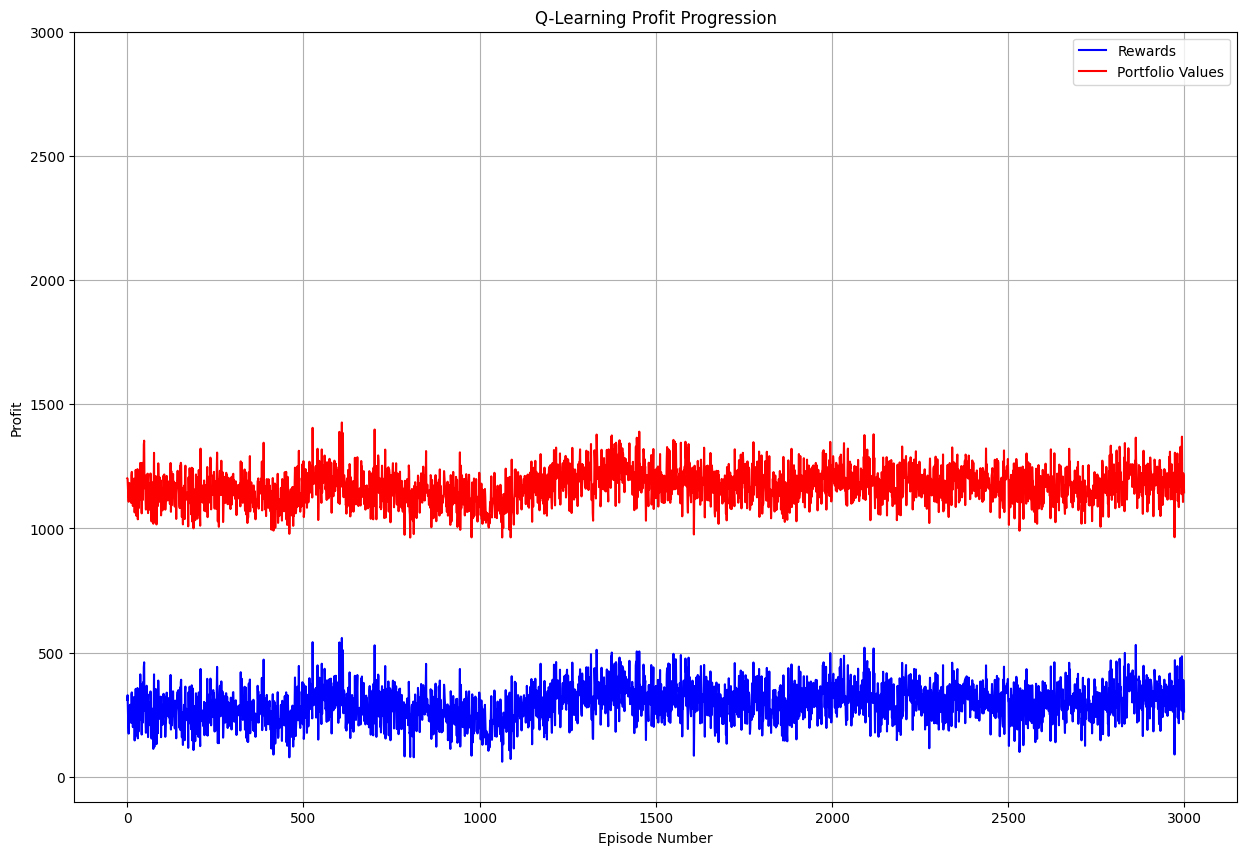

Average Reward Value Over Training: $ 296.26
Maximum Reward Value Over Training: $ 559.27
Minimum Reward Value Over Training: $ 60.99
------------------------------------------------------------------
Average Portfolio Value Over Training: $ 1171.4
Maximum Portfolio Value Over Training: $ 1426.88
Minimum Portfolio Value Over Training: $ 963.56


In [21]:
plt.figure(figsize=(15, 10))
plt.plot(rewards1, label='Rewards', linestyle='-',color='blue')
plt.plot(profits1, label='Portfolio Values', linestyle='-', color='red')
plt.title('Q-Learning Profit Progression')
plt.xlabel('Episode Number')
plt.ylabel('Profit')
plt.legend()
plt.grid(True)
plt.ylim(-100, 3000)
plt.show()

print("Average Reward Value Over Training: $", round(np.mean(rewards1),2))
print("Maximum Reward Value Over Training: $", round(np.max(rewards1),2))
print("Minimum Reward Value Over Training: $", round(np.min(rewards1),2))
print("------------------------------------------------------------------")
print("Average Portfolio Value Over Training: $", round(np.mean(profits1),2))
print("Maximum Portfolio Value Over Training: $", round(np.max(profits1),2))
print("Minimum Portfolio Value Over Training: $", round(np.min(profits1),2))

So on avergae, we are turning our 1000 USD initial investment into 1167.05 USD but we see the algorithm acting quite stable above with a high of 1420.69 USD and low of 976.52 USD.

## 4 <a id="step4">(Deep Q-Learning Algorithm) Implement a Deep Q-Learning (DQN) Agent and Evaluate Performance</a>
<a href="#contents">^ Contents</a>

Now the DQN builds upon the simple Q-Learning algorithm as follows:

1. Builds a simple neural network with an input layer, one hidden layer, and an output layer. And then it copies the weights from the policy network to the target network to synchronize them (*cloning*). This ensures the target network is a stable reference for Q-value updates during training.
2. It then chooses the exploitation version of the action using a prediction from the policy network.
3. Experience storage and replay which updates the corresponding Q-value in the current state based on the calculated target, then trains the policy network on this updated Q-value.
4. The reward is the same as in the simple Q-Learning algorithm, simply removing negative rewards and replacing them with 0.
5. We will be including regularization and/or dropout to the Q-network to help avoid overfitting, incentivize generalization, and obtain better training stability.

References: 
1. https://github.com/Albert-Z-Guo/Deep-Reinforcement-Stock-Trading/tree/master
2. https://medium.com/@shruti.dhumne/deep-q-network-dqn-90e1a8799871
3. https://github.com/conditionWang/DRQN_Stock_Trading
4. https://medium.com/@murrawang/deep-q-network-and-its-application-in-algorithmic-trading-16440a112e04

Note also that we will be showing a few variations of the DQN where some aspects are either added or removed to see if stability/convergence can be reached through training.

### 4.1 <a id="step41">DQN with Policy and Target Network</a>
[^ Contents](#contents)

Note that I will also show an execution of the NN with only a policy network in **Part 3**.

In [13]:
class DQNAgent:
    def __init__(self, state_size, action_size, learning_rate=0.001, 
                 discount_factor=0.99, epsilon=1.0, epsilon_decay=0.995, 
                 epsilon_min=0.01, batch_size=32, memory_size=2000,
                 target_update_freq=10):

        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.memory = deque(maxlen=memory_size)
        
        # main policy network and target network
        self.model = self._build_model()  # policy network to predict q-values for action
        self.target_model = clone_model(self.model)  # target network used for providing stable target q-values
        self.update_target_model()  # ensure target network has syncronized as the policy network
        self.target_update_freq = target_update_freq # sets frequency at which weights are updated

    # create the policy network (simple single layer model to expedite training and processing time)
    def _build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(self.action_size, activation='linear')) # output layer for action size
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    # update the target network weights with the policy network weights at a specified interval
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    # store experiences in memory
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    # choose action 
    def choose_action(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)  # EXPLORE
        else:
            q_values = self.model.predict(state)  # EXPLOIT - predict using policy network
            return np.argmax(q_values[0])

    # experience replay to train the policy network using experiences from memory
    def replay(self):
        if len(self.memory) < self.batch_size:
            return # stop replay if not enough memory

        batch = random.sample(self.memory, self.batch_size) # sample from memory

        for state, action, reward, next_state, done in batch:
            q_target = reward  # default reward

            if not done:  # if episode is not over, apply Bellman piecewise
                future_q = np.amax(self.target_model.predict(next_state)[0]) # predict best q-value for next state using target
                q_target += self.discount_factor * future_q # apply Bellman

            q_values = self.model.predict(state)  # get current q-values for state using policy network
            q_values[0][action] = q_target  # update q-value for action with above calculated target q-value

            self.model.fit(state, q_values, epochs=1, verbose=0)  # train policy network on the updated q-values

        # decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


    # analyze action distribution
    # NOTE this has nothing to do with algo just part of post-analysis
    def analyze_action_distribution(self):
        actions = [exp[1] for exp in self.memory]  # get all actions from memory
        unique, counts = np.unique(actions, return_counts=True)  # get unique actions and counts
        action_distribution = dict(zip(unique, counts))
        return action_distribution
        
# calculate reward which rewards buying low and selling high but updates above with no negative rewards, just 0
def calculate_reward(prev_action, prev_price, current_price, num_stocks_held):
    if prev_action == 0:  # buy
        reward = max(0, current_price - prev_price)  # potential profit
    
    elif prev_action == 1:  # sell
        reward = max(0, prev_price - current_price)  # loss avoidance
    
    else:
        reward = 0  # hold

    # additional reward for overall portfolio increase
    if num_stocks_held > 0:
        reward += (current_price - prev_price) * num_stocks_held
    
    return round(reward, 2)

# train DQN
def train_dqn(state_matrix, action_space, num_episodes, max_budget, update_freq=25, target_update_freq=50):
    # init agent
    agent = DQNAgent(
        state_size=state_matrix.shape[1], 
        action_size=len(action_space), 
        target_update_freq=target_update_freq
    )
    
    # init portfolio value, reward value and total steps (for update freq)
    profits = []
    rewards = []
    total_steps = 0

    # loop through episodes
    for episode in range(num_episodes):
        # init episode values
        total_reward = 0
        num_stocks_held = 0
        available_budget = max_budget
        state = state_matrix[0].reshape(1, -1)
        
        prev_portfolio_value = available_budget  # portfolio value at the start
        prev_action = None  # track previous action for reward

        # init tracked actions
        buys = 0 
        sells = 0

        # loop through state matrix
        for t in range(1, len(state_matrix) - 1):
            action = agent.choose_action(state) # choose action
            next_state = state_matrix[t + 1].reshape(1, -1) # pick next state

            current_price = state_matrix[t, 0] # set today price
            prev_price = state_matrix[t-1, 0] # set yesterday price

            # calculate the portfolio value today
            current_portfolio_value = available_budget + (num_stocks_held * current_price)

            # calculate reward based on the updated reward function (i.e. what profit did action yesterday get me)
            reward = calculate_reward(prev_action, prev_price, current_price, num_stocks_held)

            # track the previous action for reward calculation
            prev_action = action

            # update budget and inventory based on the action
            if action == 0 and available_budget >= current_price:  # buy if i have budget
                # adjust inventory, budget, and tracking
                num_stocks_held += 1
                available_budget -= current_price
                buys += 1
            elif action == 1 and num_stocks_held > 0:  # sell if i have inventory
                # adjust inventory, budget, and tracking
                num_stocks_held -= 1
                available_budget += current_price
                sells += 1

            # code needs to process the next state, which would not be possible on the very last step.
            done = (t == len(state_matrix) - 2)  # check if at the end of episode

            # store experience in agent memory
            agent.remember(state, action, reward, next_state, done)

            # run replay if replay running frequency is reached
            # NOTE THIS HAD TO BE DONE IN ORDER TO SPEED UP PROCESSING TIME
            if total_steps % update_freq == 0:
                agent.replay() 
            
            # update weights of target network from policy network is update frequency is reached
            if total_steps % agent.target_update_freq == 0:
                agent.update_target_model()

            # update state and total reward
            total_reward += reward
            state = next_state
            total_steps += 1 # update frequency counter

            # update the portfolio value
            prev_portfolio_value = current_portfolio_value

        # calculate final portfolio value
        final_portfolio_value = available_budget + (num_stocks_held * state_matrix[-1, 0])

        # record profit/portfolio values and total rewards
        profits.append(final_portfolio_value)
        rewards.append(total_reward)

        if episode % 50 == 0:
            print(
                f"Episode {episode + 1}, "
                f"# Stocks: {num_stocks_held}, "
                f"Total Rewards: {total_reward:.2f}, "
                f"Final Portfolio Value: {final_portfolio_value:.2f}, "
                f"Available Budget: {available_budget:.2f}, "
                f"Buys: {buys}, "
                f"Sells: {sells}"
            )

    return agent, profits, rewards


In [14]:
agent5, profits5, rewards5 = train_dqn(lagged_df.values, action_space=[0, 1, 2], 
                                    num_episodes=1000, max_budget=1000, update_freq=10, target_update_freq=10)

Episode 1, # Stocks: 5, Total Rewards: 251.02, Final Portfolio Value: 1153.31, Available Budget: 216.11, Buys: 59, Sells: 54
Episode 51, # Stocks: 0, Total Rewards: 366.31, Final Portfolio Value: 1248.47, Available Budget: 1248.47, Buys: 24, Sells: 24
Episode 101, # Stocks: 6, Total Rewards: 248.91, Final Portfolio Value: 1132.98, Available Budget: 8.34, Buys: 36, Sells: 30
Episode 151, # Stocks: 6, Total Rewards: 312.00, Final Portfolio Value: 1163.31, Available Budget: 38.67, Buys: 17, Sells: 11
Episode 201, # Stocks: 3, Total Rewards: 141.60, Final Portfolio Value: 1046.79, Available Budget: 484.47, Buys: 13, Sells: 10
Episode 251, # Stocks: 0, Total Rewards: 171.83, Final Portfolio Value: 1045.46, Available Budget: 1045.46, Buys: 12, Sells: 12
Episode 301, # Stocks: 7, Total Rewards: 571.30, Final Portfolio Value: 1455.44, Available Budget: 143.36, Buys: 15, Sells: 8
Episode 351, # Stocks: 6, Total Rewards: 283.12, Final Portfolio Value: 1171.58, Available Budget: 46.94, Buys: 8, S

In [15]:
print("Average Reward Value Over Training: $", round(np.mean(rewards5),2))
print("Maximum Reward Value Over Training: $", round(np.max(rewards5),2))
print("Minimum Reward Value Over Training: $", round(np.min(rewards5),2))
print("------------------------------------------------------------------")
print("Average Portfolio Value Over Training: $", round(np.mean(profits5),2))
print("Maximum Portfolio Value Over Training: $", round(np.max(profits5),2))
print("Minimum Portfolio Value Over Training: $", round(np.min(profits5),2))

Average Reward Value Over Training: $ 403.88
Maximum Reward Value Over Training: $ 814.34
Minimum Reward Value Over Training: $ 13.57
------------------------------------------------------------------
Average Portfolio Value Over Training: $ 1255.2
Maximum Portfolio Value Over Training: $ 1612.21
Minimum Portfolio Value Over Training: $ 940.64


In [16]:
rewards = rewards5
profits = profits5

fig = go.Figure()

# reward line
fig.add_trace(go.Scatter(x=list(range(len(rewards))), y=rewards, 
                         mode='lines', 
                         name='Rewards', 
                         line=dict(color='blue', dash='solid')))  # solid line with blue color

# portfolio line
fig.add_trace(go.Scatter(x=list(range(len(profits))), y=profits, 
                         mode='lines', 
                         name='Portfolio Values', 
                         line=dict(color='red', dash='solid')))  # solid line with red color

# plot figure
fig.update_layout(
    title='Q-Learning Profit Progression',
    xaxis=dict(title='Episode Number'),
    yaxis=dict(title='Profit', range=[-100, 5000]), 
    legend=dict(orientation='h', x=0.5, xanchor='center', y=-0.2),
    plot_bgcolor='white', 
    yaxis_showgrid=True, 
    xaxis_showgrid=True
)

# Show the plot
fig.show()

So we are seeing generally that the more we update replay and target networks the higher highs our algorithm can have on average. We are not seeing true convergence here though although the agent does tend to stay within a range as shown here.

### 4.2 <a id="step42">DQN with Policy Network Only</a>
[^ Contents](#contents)

In [17]:
class DQNAgent:
    def __init__(self, state_size, action_size, learning_rate=0.001, 
                 discount_factor=0.99, epsilon=1.0, epsilon_decay=0.995, 
                 epsilon_min=0.01, batch_size=32, memory_size=2000):

        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.memory = deque(maxlen=memory_size)
        
        # main policy network and target network
        self.model = self._build_model()  # policy network to predict q-values for action

    # create the policy network (simple single layer model to expedite training and processing time)
    def _build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(self.action_size, activation='linear')) # output layer for action size
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    # store experiences in memory
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    # choose action 
    def choose_action(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)  # EXPLORE
        else:
            q_values = self.model.predict(state)  # EXPLOIT - predict using policy network
            return np.argmax(q_values[0])

    # experience replay to train the policy network using experiences from memory
    def replay(self):
        if len(self.memory) < self.batch_size:
            return # stop replay if not enough memory

        batch = random.sample(self.memory, self.batch_size) # sample from memory

        for state, action, reward, next_state, done in batch:
            q_target = reward  # default reward

            if not done:  # if episode is not over, apply Bellman piecewise
                future_q = np.amax(self.model.predict(next_state)[0]) # predict best q-value for next state using target
                q_target += self.discount_factor * future_q # apply Bellman

            q_values = self.model.predict(state)  # get current q-values for state using policy network
            q_values[0][action] = q_target  # update q-value for action with above calculated target q-value

            self.model.fit(state, q_values, epochs=1, verbose=0)  # train policy network on the updated q-values

        # decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


    # analyze action distribution
    # NOTE this has nothing to do with algo just part of post-analysis
    def analyze_action_distribution(self):
        actions = [exp[1] for exp in self.memory]  # get all actions from memory
        unique, counts = np.unique(actions, return_counts=True)  # get unique actions and counts
        action_distribution = dict(zip(unique, counts))
        return action_distribution
        
# calculate reward which rewards buying low and selling high but updates above with no negative rewards, just 0
def calculate_reward(prev_action, prev_price, current_price, num_stocks_held):
    if prev_action == 0:  # buy
        reward = max(0, current_price - prev_price)  # potential profit
    
    elif prev_action == 1:  # sell
        reward = max(0, prev_price - current_price)  # loss avoidance
    
    else:
        reward = 0  # hold

    # additional reward for overall portfolio increase
    if num_stocks_held > 0:
        reward += (current_price - prev_price) * num_stocks_held
    
    return round(reward, 2)

# train DQN
def train_dqn(state_matrix, action_space, num_episodes, max_budget, update_freq=25):
    # init agent
    agent = DQNAgent(
        state_size=state_matrix.shape[1], 
        action_size=len(action_space)
    )
    
    # init portfolio value, reward value and total steps (for update freq)
    profits = []
    rewards = []
    total_steps = 0

    # loop through episodes
    for episode in range(num_episodes):
        # init episode values
        total_reward = 0
        num_stocks_held = 0
        available_budget = max_budget
        state = state_matrix[0].reshape(1, -1)
        
        prev_portfolio_value = available_budget  # portfolio value at the start
        prev_action = None  # track previous action for reward

        # init tracked actions
        buys = 0 
        sells = 0

        # loop through state matrix
        for t in range(1, len(state_matrix) - 1):
            action = agent.choose_action(state) # choose action
            next_state = state_matrix[t + 1].reshape(1, -1) # pick next state

            current_price = state_matrix[t, 0] # set today price
            prev_price = state_matrix[t-1, 0] # set yesterday price

            # calculate the portfolio value today
            current_portfolio_value = available_budget + (num_stocks_held * current_price)

            # calculate reward based on the updated reward function (i.e. what profit did action yesterday get me)
            reward = calculate_reward(prev_action, prev_price, current_price, num_stocks_held)

            # track the previous action for reward calculation
            prev_action = action

            # update budget and inventory based on the action
            if action == 0 and available_budget >= current_price:  # buy if i have budget
                # adjust inventory, budget, and tracking
                num_stocks_held += 1
                available_budget -= current_price
                buys += 1
            elif action == 1 and num_stocks_held > 0:  # sell if i have inventory
                # adjust inventory, budget, and tracking
                num_stocks_held -= 1
                available_budget += current_price
                sells += 1

            done = (t == len(state_matrix) - 2)  # check if at the end of episode

            # store experience in agent memory
            agent.remember(state, action, reward, next_state, done)

            # run replay if replay running frequency is reached
            # NOTE THIS HAD TO BE DONE IN ORDER TO SPEED UP PROCESSING TIME
            if total_steps % update_freq == 0:
                agent.replay() 

            # update state and total reward
            total_reward += reward
            state = next_state
            total_steps += 1 # update frequency counter

            # update the portfolio value
            prev_portfolio_value = current_portfolio_value

        # calculate final portfolio value
        final_portfolio_value = available_budget + (num_stocks_held * state_matrix[-1, 0])

        # record profit/portfolio values and total rewards
        profits.append(final_portfolio_value)
        rewards.append(total_reward)

        if episode % 50 == 0:
            print(
                f"Episode {episode + 1}, "
                f"# Stocks: {num_stocks_held}, "
                f"Total Rewards: {total_reward:.2f}, "
                f"Final Portfolio Value: {final_portfolio_value:.2f}, "
                f"Available Budget: {available_budget:.2f}, "
                f"Buys: {buys}, "
                f"Sells: {sells}"
            )

    return agent, profits, rewards


In [19]:
agent6, profits6, rewards6 = train_dqn(lagged_df.values, action_space=[0, 1, 2], 
                                    num_episodes=1000, max_budget=1000, update_freq=10)

Episode 1, # Stocks: 6, Total Rewards: 292.62, Final Portfolio Value: 1217.24, Available Budget: 92.60, Buys: 60, Sells: 54
Episode 51, # Stocks: 0, Total Rewards: 464.34, Final Portfolio Value: 1239.91, Available Budget: 1239.91, Buys: 50, Sells: 50
Episode 101, # Stocks: 0, Total Rewards: 258.14, Final Portfolio Value: 1082.62, Available Budget: 1082.62, Buys: 29, Sells: 29
Episode 151, # Stocks: 6, Total Rewards: 330.99, Final Portfolio Value: 1213.40, Available Budget: 88.76, Buys: 21, Sells: 15
Episode 201, # Stocks: 7, Total Rewards: 476.67, Final Portfolio Value: 1319.80, Available Budget: 7.72, Buys: 17, Sells: 10
Episode 251, # Stocks: 6, Total Rewards: 258.27, Final Portfolio Value: 1175.78, Available Budget: 51.14, Buys: 16, Sells: 10
Episode 301, # Stocks: 0, Total Rewards: 298.56, Final Portfolio Value: 1187.92, Available Budget: 1187.92, Buys: 15, Sells: 15
Episode 351, # Stocks: 6, Total Rewards: 364.57, Final Portfolio Value: 1260.12, Available Budget: 135.48, Buys: 9, 

In [20]:
print("Average Reward Value Over Training: $", round(np.mean(rewards6),2))
print("Maximum Reward Value Over Training: $", round(np.max(rewards6),2))
print("Minimum Reward Value Over Training: $", round(np.min(rewards6),2))
print("------------------------------------------------------------------")
print("Average Portfolio Value Over Training: $", round(np.mean(profits6),2))
print("Maximum Portfolio Value Over Training: $", round(np.max(profits6),2))
print("Minimum Portfolio Value Over Training: $", round(np.min(profits6),2))

Average Reward Value Over Training: $ 360.8
Maximum Reward Value Over Training: $ 733.19
Minimum Reward Value Over Training: $ -1.23
------------------------------------------------------------------
Average Portfolio Value Over Training: $ 1208.92
Maximum Portfolio Value Over Training: $ 1525.76
Minimum Portfolio Value Over Training: $ 885.83


In [21]:
rewards = rewards6
profits = profits6

fig = go.Figure()

# reward line
fig.add_trace(go.Scatter(x=list(range(len(rewards))), y=rewards, 
                         mode='lines', 
                         name='Rewards', 
                         line=dict(color='blue', dash='solid')))  # solid line with blue color

# portfolio line
fig.add_trace(go.Scatter(x=list(range(len(profits))), y=profits, 
                         mode='lines', 
                         name='Portfolio Values', 
                         line=dict(color='red', dash='solid')))  # solid line with red color

# plot figure
fig.update_layout(
    title='Q-Learning Profit Progression',
    xaxis=dict(title='Episode Number'),
    yaxis=dict(title='Profit', range=[-100, 5000]), 
    legend=dict(orientation='h', x=0.5, xanchor='center', y=-0.2),
    plot_bgcolor='white', 
    yaxis_showgrid=True, 
    xaxis_showgrid=True
)

# Show the plot
fig.show()

We are now seeing here that as we are only using a policy network, it might seem slightly more erratic, I'm not sure. We can see when comparing this to the use of policy and target network that there is a bit more of a range where the rewards and portfolio value operate within and my belief is that this is because the target network is not helping with overall stability.

### 4.3 <a id="step43">DQN with Policy Network Only But No Replay</a>
[^ Contents](#contents)

In [22]:
class DQNAgent:
    def __init__(self, state_size, action_size, learning_rate=0.001, 
                 discount_factor=0.99, epsilon=1.0, epsilon_decay=0.995, 
                 epsilon_min=0.01, batch_size=32, memory_size=2000):

        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.memory = deque(maxlen=memory_size)
        
        # main policy network and target network
        self.model = self._build_model()  # policy network to predict q-values for action

    # create the policy network (simple single layer model to expedite training and processing time)
    def _build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        #model.add(Dense(24, activation='relu'))  # Added another layer for more complexity
        model.add(Dense(self.action_size, activation='linear')) # output layer for action size
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    # store experiences in memory
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    # choose action 
    def choose_action(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)  # EXPLORE
        else:
            q_values = self.model.predict(state)  # EXPLOIT - predict using policy network
            return np.argmax(q_values[0])

    # experience replay to train the policy network using experiences from memory
    def replay(self):
        if len(self.memory) < self.batch_size:
            return # stop replay if not enough memory

        batch = random.sample(self.memory, self.batch_size) # sample from memory

        for state, action, reward, next_state, done in batch:
            q_target = reward  # default reward

            if not done:  # if episode is not over, apply Bellman piecewise
                future_q = np.amax(self.model.predict(next_state)[0]) # predict best q-value for next state using target
                q_target += self.discount_factor * future_q # apply Bellman

            q_values = self.model.predict(state)  # get current q-values for state using policy network
            q_values[0][action] = q_target  # update q-value for action with above calculated target q-value

            self.model.fit(state, q_values, epochs=1, verbose=0)  # train policy network on the updated q-values

        # decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


    # analyze action distribution
    # NOTE this has nothing to do with algo just part of post-analysis
    def analyze_action_distribution(self):
        actions = [exp[1] for exp in self.memory]  # get all actions from memory
        unique, counts = np.unique(actions, return_counts=True)  # get unique actions and counts
        action_distribution = dict(zip(unique, counts))
        return action_distribution
        
# calculate reward which rewards buying low and selling high but updates above with no negative rewards, just 0
def calculate_reward(prev_action, prev_price, current_price, num_stocks_held):
    if prev_action == 0:  # buy
        reward = max(0, current_price - prev_price)  # potential profit
    
    elif prev_action == 1:  # sell
        reward = max(0, prev_price - current_price)  # loss avoidance
    
    else:
        reward = 0  # hold

    # additional reward for overall portfolio increase
    if num_stocks_held > 0:
        reward += (current_price - prev_price) * num_stocks_held
    
    return round(reward, 2)

# train DQN
def train_dqn(state_matrix, action_space, num_episodes, max_budget, update_freq=25):
    # init agent
    agent = DQNAgent(
        state_size=state_matrix.shape[1], 
        action_size=len(action_space)
    )
    
    # init portfolio value, reward value and total steps (for update freq)
    profits = []
    rewards = []
    total_steps = 0

    # loop through episodes
    for episode in range(num_episodes):
        # init episode values
        total_reward = 0
        num_stocks_held = 0
        available_budget = max_budget
        state = state_matrix[0].reshape(1, -1)
        
        prev_portfolio_value = available_budget  # portfolio value at the start
        prev_action = None  # track previous action for reward

        # init tracked actions
        buys = 0 
        sells = 0

        # loop through state matrix
        for t in range(1, len(state_matrix) - 1):
            action = agent.choose_action(state) # choose action
            next_state = state_matrix[t + 1].reshape(1, -1) # pick next state

            current_price = state_matrix[t, 0] # set today price
            prev_price = state_matrix[t-1, 0] # set yesterday price

            # calculate the portfolio value today
            current_portfolio_value = available_budget + (num_stocks_held * current_price)

            # calculate reward based on the updated reward function (i.e. what profit did action yesterday get me)
            reward = calculate_reward(prev_action, prev_price, current_price, num_stocks_held)

            # track the previous action for reward calculation
            prev_action = action

            # update budget and inventory based on the action
            if action == 0 and available_budget >= current_price:  # buy if i have budget
                # adjust inventory, budget, and tracking
                num_stocks_held += 1
                available_budget -= current_price
                buys += 1
            elif action == 1 and num_stocks_held > 0:  # sell if i have inventory
                # adjust inventory, budget, and tracking
                num_stocks_held -= 1
                available_budget += current_price
                sells += 1

            done = (t == len(state_matrix) - 2)  # check if at the end of episode

            # store experience in agent memory
            agent.remember(state, action, reward, next_state, done)

            # run replay if replay running frequency is reached
            # NOTE THIS HAD TO BE DONE IN ORDER TO SPEED UP PROCESSING TIME
            #if total_steps % update_freq == 0:
            #    agent.replay() 

            # update state and total reward
            total_reward += reward
            state = next_state
            total_steps += 1 # update frequency counter

            # update the portfolio value
            prev_portfolio_value = current_portfolio_value

        # calculate final portfolio value
        final_portfolio_value = available_budget + (num_stocks_held * state_matrix[-1, 0])

        # record profit/portfolio values and total rewards
        profits.append(final_portfolio_value)
        rewards.append(total_reward)

        if episode % 50 == 0:
            print(
                f"Episode {episode + 1}, "
                f"# Stocks: {num_stocks_held}, "
                f"Total Rewards: {total_reward:.2f}, "
                f"Final Portfolio Value: {final_portfolio_value:.2f}, "
                f"Available Budget: {available_budget:.2f}, "
                f"Buys: {buys}, "
                f"Sells: {sells}"
            )

    return agent, profits, rewards


In [23]:
agent7, profits7, rewards7 = train_dqn(lagged_df.values, action_space=[0, 1, 2], 
                                    num_episodes=3000, max_budget=1000, update_freq=10)

Episode 1, # Stocks: 4, Total Rewards: 277.14, Final Portfolio Value: 1144.71, Available Budget: 394.95, Buys: 57, Sells: 53
Episode 51, # Stocks: 0, Total Rewards: 262.17, Final Portfolio Value: 1168.33, Available Budget: 1168.33, Buys: 57, Sells: 57
Episode 101, # Stocks: 3, Total Rewards: 317.44, Final Portfolio Value: 1216.41, Available Budget: 654.09, Buys: 56, Sells: 53
Episode 151, # Stocks: 3, Total Rewards: 326.98, Final Portfolio Value: 1202.30, Available Budget: 639.98, Buys: 65, Sells: 62
Episode 201, # Stocks: 5, Total Rewards: 141.61, Final Portfolio Value: 1037.44, Available Budget: 100.24, Buys: 63, Sells: 58
Episode 251, # Stocks: 0, Total Rewards: 245.94, Final Portfolio Value: 1128.83, Available Budget: 1128.83, Buys: 60, Sells: 60
Episode 301, # Stocks: 0, Total Rewards: 244.22, Final Portfolio Value: 1137.65, Available Budget: 1137.65, Buys: 61, Sells: 61
Episode 351, # Stocks: 1, Total Rewards: 276.54, Final Portfolio Value: 1166.00, Available Budget: 978.56, Buys

In [24]:
print("Average Reward Value Over Training: $", round(np.mean(rewards7),2))
print("Maximum Reward Value Over Training: $", round(np.max(rewards7),2))
print("Minimum Reward Value Over Training: $", round(np.min(rewards7),2))
print("------------------------------------------------------------------")
print("Average Portfolio Value Over Training: $", round(np.mean(profits7),2))
print("Maximum Portfolio Value Over Training: $", round(np.max(profits7),2))
print("Minimum Portfolio Value Over Training: $", round(np.min(profits7),2))

Average Reward Value Over Training: $ 238.84
Maximum Reward Value Over Training: $ 491.51
Minimum Reward Value Over Training: $ 17.49
------------------------------------------------------------------
Average Portfolio Value Over Training: $ 1127.53
Maximum Portfolio Value Over Training: $ 1360.54
Minimum Portfolio Value Over Training: $ 940.39


In [25]:
rewards = rewards7
profits = profits7

fig = go.Figure()

# reward line
fig.add_trace(go.Scatter(x=list(range(len(rewards))), y=rewards, 
                         mode='lines', 
                         name='Rewards', 
                         line=dict(color='blue', dash='solid')))  # solid line with blue color

# portfolio line
fig.add_trace(go.Scatter(x=list(range(len(profits))), y=profits, 
                         mode='lines', 
                         name='Portfolio Values', 
                         line=dict(color='red', dash='solid')))  # solid line with red color

# plot figure
fig.update_layout(
    title='Q-Learning Profit Progression',
    xaxis=dict(title='Episode Number'),
    yaxis=dict(title='Profit', range=[-100, 5000]), 
    legend=dict(orientation='h', x=0.5, xanchor='center', y=-0.2),
    plot_bgcolor='white', 
    yaxis_showgrid=True, 
    xaxis_showgrid=True
)

# Show the plot
fig.show()

This is frankly stagnant without the experience replay. This is because the neural network is not being trained with experiences from the replay function. It is definitely more stable, but not hitting the higher average portfolio value that we saw with the experience replay and double networks (policy and target). The agent also is not converging although it's erratic behavior seems to be less, which is because the random experience replay is not retraining the Q-network. However, this means we might as well just use the Q-table method.

### 4.4 <a id="step44">DQN with Policy Network and Regularization</a>
[^ Contents](#contents)

Basically I read that adding regularization helps control overfitting, leading to a more robust and generalized policy network for the DQN agent. This makes the training process more stable and increases the likelihood of convergence. This is because regularization will penalize larger weights and dropout (not included here but in part 4.5) will randomly remove neurons so the remaining weights are forced to work and generalize better. Generally a value of 0.2 is a good starting point for both but a value too high could cause adverse effects (too much generalization).

References:
1. https://arxiv.org/pdf/1810.00123
2. https://medium.com/analytics-vidhya/regularization-understanding-l1-and-l2-regularization-for-deep-learning-a7b9e4a409bf
3. https://www.e2enetworks.com/blog/regularization-in-deep-learning-l1-l2-dropout
4. https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/

In [26]:
class DQNAgent:
    def __init__(self, state_size, action_size, learning_rate=0.001, 
                 discount_factor=0.99, epsilon=1.0, epsilon_decay=0.995, 
                 epsilon_min=0.01, batch_size=32, memory_size=2000):

        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.memory = deque(maxlen=memory_size)
        
        # main policy network and target network
        self.model = self._build_model()  # policy network to predict q-values for action

    # create the policy network (simple single layer model to expedite training and processing time)
    def _build_model(self):
        regularization_strength = 0.01  # lambda

        model = Sequential()
        model.add(Dense(
            24, 
            input_dim=self.state_size, 
            activation='relu', 
            kernel_regularizer=l2(regularization_strength)
        ))
        # model.add(Dropout(0.2))  # dropout with 20% probability, we will keep commented out till next variation
        
        model.add(Dense(
            self.action_size, 
            activation='linear', 
            kernel_regularizer=l2(regularization_strength)  # L2 on output layer
        ))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    # store experiences in memory
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    # choose action 
    def choose_action(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)  # EXPLORE
        else:
            q_values = self.model.predict(state)  # EXPLOIT - predict using policy network
            return np.argmax(q_values[0])

    # experience replay to train the policy network using experiences from memory
    def replay(self):
        if len(self.memory) < self.batch_size:
            return # stop replay if not enough memory

        batch = random.sample(self.memory, self.batch_size) # sample from memory

        for state, action, reward, next_state, done in batch:
            q_target = reward  # default reward

            if not done:  # if episode is not over, apply Bellman piecewise
                future_q = np.amax(self.model.predict(next_state)[0]) # predict best q-value for next state using target
                q_target += self.discount_factor * future_q # apply Bellman

            q_values = self.model.predict(state)  # get current q-values for state using policy network
            q_values[0][action] = q_target  # update q-value for action with above calculated target q-value

            self.model.fit(state, q_values, epochs=1, verbose=0)  # train policy network on the updated q-values

        # decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


    # analyze action distribution
    # NOTE this has nothing to do with algo just part of post-analysis
    def analyze_action_distribution(self):
        actions = [exp[1] for exp in self.memory]  # get all actions from memory
        unique, counts = np.unique(actions, return_counts=True)  # get unique actions and counts
        action_distribution = dict(zip(unique, counts))
        return action_distribution
        
# calculate reward which rewards buying low and selling high but updates above with no negative rewards, just 0
def calculate_reward(prev_action, prev_price, current_price, num_stocks_held):
    if prev_action == 0:  # buy
        reward = max(0, current_price - prev_price)  # potential profit
    
    elif prev_action == 1:  # sell
        reward = max(0, prev_price - current_price)  # loss avoidance
    
    else:
        reward = 0  # hold

    # additional reward for overall portfolio increase
    if num_stocks_held > 0:
        reward += (current_price - prev_price) * num_stocks_held
    
    return round(reward, 2)

# train DQN
def train_dqn(state_matrix, action_space, num_episodes, max_budget, update_freq=25):
    # init agent
    agent = DQNAgent(
        state_size=state_matrix.shape[1], 
        action_size=len(action_space)
    )
    
    # init portfolio value, reward value and total steps (for update freq)
    profits = []
    rewards = []
    total_steps = 0

    # loop through episodes
    for episode in range(num_episodes):
        # init episode values
        total_reward = 0
        num_stocks_held = 0
        available_budget = max_budget
        state = state_matrix[0].reshape(1, -1)
        
        prev_portfolio_value = available_budget  # portfolio value at the start
        prev_action = None  # track previous action for reward

        # init tracked actions
        buys = 0 
        sells = 0

        # loop through state matrix
        for t in range(1, len(state_matrix) - 1):
            action = agent.choose_action(state) # choose action
            next_state = state_matrix[t + 1].reshape(1, -1) # pick next state

            current_price = state_matrix[t, 0] # set today price
            prev_price = state_matrix[t-1, 0] # set yesterday price

            # calculate the portfolio value today
            current_portfolio_value = available_budget + (num_stocks_held * current_price)

            # calculate reward based on the updated reward function (i.e. what profit did action yesterday get me)
            reward = calculate_reward(prev_action, prev_price, current_price, num_stocks_held)

            # track the previous action for reward calculation
            prev_action = action

            # update budget and inventory based on the action
            if action == 0 and available_budget >= current_price:  # buy if i have budget
                # adjust inventory, budget, and tracking
                num_stocks_held += 1
                available_budget -= current_price
                buys += 1
            elif action == 1 and num_stocks_held > 0:  # sell if i have inventory
                # adjust inventory, budget, and tracking
                num_stocks_held -= 1
                available_budget += current_price
                sells += 1

            done = (t == len(state_matrix) - 2)  # check if at the end of episode

            # store experience in agent memory
            agent.remember(state, action, reward, next_state, done)

            # run replay if replay running frequency is reached
            # NOTE THIS HAD TO BE DONE IN ORDER TO SPEED UP PROCESSING TIME
            if total_steps % update_freq == 0:
                agent.replay() 

            # update state and total reward
            total_reward += reward
            state = next_state
            total_steps += 1 # update frequency counter

            # update the portfolio value
            prev_portfolio_value = current_portfolio_value

        # calculate final portfolio value
        final_portfolio_value = available_budget + (num_stocks_held * state_matrix[-1, 0])

        # record profit/portfolio values and total rewards
        profits.append(final_portfolio_value)
        rewards.append(total_reward)

        if episode % 50 == 0:
            print(
                f"Episode {episode + 1}, "
                f"# Stocks: {num_stocks_held}, "
                f"Total Rewards: {total_reward:.2f}, "
                f"Final Portfolio Value: {final_portfolio_value:.2f}, "
                f"Available Budget: {available_budget:.2f}, "
                f"Buys: {buys}, "
                f"Sells: {sells}"
            )

    return agent, profits, rewards


In [28]:
agent8, profits8, rewards8 = train_dqn(lagged_df.values, action_space=[0, 1, 2], 
                                    num_episodes=1000, max_budget=1000, update_freq=10)

Episode 1, # Stocks: 5, Total Rewards: 264.98, Final Portfolio Value: 1163.96, Available Budget: 226.76, Buys: 68, Sells: 63
Episode 51, # Stocks: 0, Total Rewards: 137.23, Final Portfolio Value: 1001.81, Available Budget: 1001.81, Buys: 20, Sells: 20
Episode 101, # Stocks: 6, Total Rewards: 303.38, Final Portfolio Value: 1195.82, Available Budget: 71.18, Buys: 15, Sells: 9
Episode 151, # Stocks: 7, Total Rewards: 509.87, Final Portfolio Value: 1358.21, Available Budget: 46.13, Buys: 27, Sells: 20
Episode 201, # Stocks: 6, Total Rewards: 227.71, Final Portfolio Value: 1135.57, Available Budget: 10.93, Buys: 13, Sells: 7
Episode 251, # Stocks: 6, Total Rewards: 271.54, Final Portfolio Value: 1137.49, Available Budget: 12.85, Buys: 6, Sells: 0
Episode 301, # Stocks: 1, Total Rewards: 516.87, Final Portfolio Value: 1338.15, Available Budget: 1150.71, Buys: 15, Sells: 14
Episode 351, # Stocks: 0, Total Rewards: 412.61, Final Portfolio Value: 1237.67, Available Budget: 1237.67, Buys: 20, Se

In [29]:
print("Average Reward Value Over Training: $", round(np.mean(rewards8),2))
print("Maximum Reward Value Over Training: $", round(np.max(rewards8),2))
print("Minimum Reward Value Over Training: $", round(np.min(rewards8),2))
print("------------------------------------------------------------------")
print("Average Portfolio Value Over Training: $", round(np.mean(profits8),2))
print("Maximum Portfolio Value Over Training: $", round(np.max(profits8),2))
print("Minimum Portfolio Value Over Training: $", round(np.min(profits8),2))

Average Reward Value Over Training: $ 329.62
Maximum Reward Value Over Training: $ 735.13
Minimum Reward Value Over Training: $ -34.45
------------------------------------------------------------------
Average Portfolio Value Over Training: $ 1192.88
Maximum Portfolio Value Over Training: $ 1530.55
Minimum Portfolio Value Over Training: $ 897.71


In [30]:
rewards = rewards8
profits = profits8

fig = go.Figure()

# reward line
fig.add_trace(go.Scatter(x=list(range(len(rewards))), y=rewards, 
                         mode='lines', 
                         name='Rewards', 
                         line=dict(color='blue', dash='solid')))  # solid line with blue color

# portfolio line
fig.add_trace(go.Scatter(x=list(range(len(profits))), y=profits, 
                         mode='lines', 
                         name='Portfolio Values', 
                         line=dict(color='red', dash='solid')))  # solid line with red color

# plot figure
fig.update_layout(
    title='Q-Learning Profit Progression',
    xaxis=dict(title='Episode Number'),
    yaxis=dict(title='Profit', range=[-100, 5000]), 
    legend=dict(orientation='h', x=0.5, xanchor='center', y=-0.2),
    plot_bgcolor='white', 
    yaxis_showgrid=True, 
    xaxis_showgrid=True
)

# show the plot
fig.show()

Okay this is actually not horrible and we see a generally higher average portfolio and some stability in the curves at the end. Note that there is no dropout and only a little bit of regularization added. My guess is if we include both, we will probably see substantial stabilization in the training curve so let's try this now.

### 4.5 <a id="step45">DQN with Policy and Target Network and Regularization</a>
[^ Contents](#contents)

Ok frankly I just wanted to test regularization on the larger two network model to see if it stabilized like we see above.

In [23]:
class DQNAgent:
    def __init__(self, state_size, action_size, learning_rate=0.001, #0.001 
                 discount_factor=0.99, epsilon=1.0, epsilon_decay=0.995, 
                 epsilon_min=0.01, batch_size=32, memory_size=2000,
                 target_update_freq=100):

        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.memory = deque(maxlen=memory_size)
        
        # main policy network and target network
        self.model = self._build_model()  # policy network to predict q-values for action
        self.target_model = clone_model(self.model)  # target network used for providing stable target q-values
        self.update_target_model()  # ensure target network has syncronized as the policy network
        self.target_update_freq = target_update_freq # sets frequency at which weights are updated

    # create the policy network (simple single layer model to expedite training and processing time)
    def _build_model(self):
        regularization_strength = 0.01  # lambda weight decay penalizes larger weights
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu', kernel_regularizer=l2(regularization_strength)))
        model.add(Dropout(0.2))  # dropout drops neurons randomly at 10% prob during training to force reduce over reliance on specific neurons     
        model.add(Dense(self.action_size, activation='linear', kernel_regularizer=l2(regularization_strength)))  # L2 on output layer
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    # update the target network weights with the policy network weights at a specified interval
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    # store experiences in memory
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    # choose action 
    def choose_action(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)  # EXPLORE
        else:
            q_values = self.model.predict(state)  # EXPLOIT - predict using policy network
            return np.argmax(q_values[0])

    # experience replay to train the policy network using experiences from memory
    def replay(self):
        if len(self.memory) < self.batch_size:
            return # stop replay if not enough memory

        batch = random.sample(self.memory, self.batch_size) # sample from memory

        for state, action, reward, next_state, done in batch:
            q_target = reward  # default reward

            if not done:  # if episode is not over, apply Bellman piecewise
                future_q = np.amax(self.target_model.predict(next_state)[0]) # predict best q-value for next state using target
                q_target += self.discount_factor * future_q # apply Bellman

            q_values = self.model.predict(state)  # get current q-values for state using policy network
            q_values[0][action] = q_target  # update q-value for action with above calculated target q-value

            self.model.fit(state, q_values, epochs=1, verbose=0)  # train policy network on the updated q-values

        # decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


    # analyze action distribution
    # NOTE this has nothing to do with algo just part of post-analysis
    def analyze_action_distribution(self):
        actions = [exp[1] for exp in self.memory]  # get all actions from memory
        unique, counts = np.unique(actions, return_counts=True)  # get unique actions and counts
        action_distribution = dict(zip(unique, counts))
        return action_distribution
        
# calculate reward which rewards buying low and selling high but updates above with no negative rewards, just 0
def calculate_reward(prev_action, prev_price, current_price, num_stocks_held):
    if prev_action == 0:  # buy
        reward = max(0, current_price - prev_price)  # potential profit
    
    elif prev_action == 1:  # sell
        reward = max(0, prev_price - current_price)  # loss avoidance
    
    else:
        reward = 0  # hold

    # additional reward for overall portfolio increase
    if num_stocks_held > 0:
        reward += (current_price - prev_price) * num_stocks_held
    
    return round(reward, 2)

# train DQN
def train_dqn(state_matrix, action_space, num_episodes, max_budget, update_freq=25, target_update_freq=50):
    # init agent
    agent = DQNAgent(
        state_size=state_matrix.shape[1], 
        action_size=len(action_space), 
        target_update_freq=target_update_freq
    )
    
    # init portfolio value, reward value and total steps (for update freq)
    profits = []
    rewards = []
    total_steps = 0

    # loop through episodes
    for episode in range(num_episodes):
        # init episode values
        total_reward = 0
        num_stocks_held = 0
        available_budget = max_budget
        state = state_matrix[0].reshape(1, -1)
        
        prev_portfolio_value = available_budget  # portfolio value at the start
        prev_action = None  # track previous action for reward

        # init tracked actions
        buys = 0 
        sells = 0

        # loop through state matrix
        for t in range(1, len(state_matrix) - 1):
            action = agent.choose_action(state) # choose action
            next_state = state_matrix[t + 1].reshape(1, -1) # pick next state

            current_price = state_matrix[t, 0] # set today price
            prev_price = state_matrix[t-1, 0] # set yesterday price

            # calculate the portfolio value today
            current_portfolio_value = available_budget + (num_stocks_held * current_price)

            # calculate reward based on the updated reward function (i.e. what profit did action yesterday get me)
            reward = calculate_reward(prev_action, prev_price, current_price, num_stocks_held)

            # track the previous action for reward calculation
            prev_action = action

            # update budget and inventory based on the action
            if action == 0 and available_budget >= current_price:  # buy if i have budget
                # adjust inventory, budget, and tracking
                num_stocks_held += 1
                available_budget -= current_price
                buys += 1
            elif action == 1 and num_stocks_held > 0:  # sell if i have inventory
                # adjust inventory, budget, and tracking
                num_stocks_held -= 1
                available_budget += current_price
                sells += 1

            # code needs to process the next state, which would not be possible on the very last step.
            done = (t == len(state_matrix) - 2)  # check if at the end of episode

            # store experience in agent memory
            agent.remember(state, action, reward, next_state, done)

            # run replay if replay running frequency is reached
            # NOTE THIS HAD TO BE DONE IN ORDER TO SPEED UP PROCESSING TIME
            if total_steps % update_freq == 0:
                agent.replay() 
            
            # update weights of target network from policy network is update frequency is reached
            if total_steps % agent.target_update_freq == 0:
                agent.update_target_model()

            # update state and total reward
            total_reward += reward
            state = next_state
            total_steps += 1 # update frequency counter

            # update the portfolio value
            prev_portfolio_value = current_portfolio_value

        # calculate final portfolio value
        final_portfolio_value = available_budget + (num_stocks_held * state_matrix[-1, 0])

        # record profit/portfolio values and total rewards
        profits.append(final_portfolio_value)
        rewards.append(total_reward)

        if episode % 50 == 0:
            print(
                f"Episode {episode + 1}, "
                f"# Stocks: {num_stocks_held}, "
                f"Total Rewards: {total_reward:.2f}, "
                f"Final Portfolio Value: {final_portfolio_value:.2f}, "
                f"Available Budget: {available_budget:.2f}, "
                f"Buys: {buys}, "
                f"Sells: {sells}"
            )

    return agent, profits, rewards


In [24]:
agent9, profits9, rewards9 = train_dqn(lagged_df.values, action_space=[0, 1, 2], 
                                    num_episodes=1000, max_budget=1000, update_freq=10, target_update_freq=10)

Episode 1, # Stocks: 0, Total Rewards: 209.69, Final Portfolio Value: 1102.23, Available Budget: 1102.23, Buys: 57, Sells: 57
Episode 51, # Stocks: 7, Total Rewards: 518.86, Final Portfolio Value: 1334.27, Available Budget: 22.19, Buys: 7, Sells: 0
Episode 101, # Stocks: 7, Total Rewards: 518.86, Final Portfolio Value: 1334.27, Available Budget: 22.19, Buys: 7, Sells: 0
Episode 151, # Stocks: 7, Total Rewards: 515.68, Final Portfolio Value: 1332.68, Available Budget: 20.60, Buys: 8, Sells: 1
Episode 201, # Stocks: 7, Total Rewards: 523.68, Final Portfolio Value: 1336.68, Available Budget: 24.60, Buys: 10, Sells: 3
Episode 251, # Stocks: 7, Total Rewards: 519.28, Final Portfolio Value: 1334.48, Available Budget: 22.40, Buys: 9, Sells: 2
Episode 301, # Stocks: 7, Total Rewards: 517.57, Final Portfolio Value: 1334.27, Available Budget: 22.19, Buys: 7, Sells: 0
Episode 351, # Stocks: 7, Total Rewards: 517.50, Final Portfolio Value: 1333.59, Available Budget: 21.51, Buys: 9, Sells: 2
Episod

In [25]:
print("Average Reward Value Over Training: $", round(np.mean(rewards9),2))
print("Maximum Reward Value Over Training: $", round(np.max(rewards9),2))
print("Minimum Reward Value Over Training: $", round(np.min(rewards9),2))
print("------------------------------------------------------------------")
print("Average Portfolio Value Over Training: $", round(np.mean(profits9),2))
print("Maximum Portfolio Value Over Training: $", round(np.max(profits9),2))
print("Minimum Portfolio Value Over Training: $", round(np.min(profits9),2))

Average Reward Value Over Training: $ 514.23
Maximum Reward Value Over Training: $ 540.36
Minimum Reward Value Over Training: $ 70.73
------------------------------------------------------------------
Average Portfolio Value Over Training: $ 1331.31
Maximum Portfolio Value Over Training: $ 1346.59
Minimum Portfolio Value Over Training: $ 976.97


In [26]:
rewards = rewards9
profits = profits9

fig = go.Figure()

# reward line
fig.add_trace(go.Scatter(x=list(range(len(rewards))), y=rewards, 
                         mode='lines', 
                         name='Rewards', 
                         line=dict(color='blue', dash='solid')))  # solid line with blue color

# portfolio line
fig.add_trace(go.Scatter(x=list(range(len(profits))), y=profits, 
                         mode='lines', 
                         name='Portfolio Values', 
                         line=dict(color='red', dash='solid')))  # solid line with red color

# plot figure
fig.update_layout(
    title='Q-Learning Profit Progression',
    xaxis=dict(title='Episode Number'),
    yaxis=dict(title='Profit', range=[-100, 5000]), 
    legend=dict(orientation='h', x=0.5, xanchor='center', y=-0.2),
    plot_bgcolor='white', 
    yaxis_showgrid=True, 
    xaxis_showgrid=True
)

# show the plot
fig.show()

This looks like it is converging well with a few small up and down ticks. This has to be due to the implementation of the double networks and the regularization/dropout portions added to the Q-network. We also see an average $1329.99 portfolio value which is the best average we have seen with the other variations.

## 5 <a id="step5">(Future Considerations) Notes On Potential Future Areas For Research</a>
<a href="#contents">^ Contents</a>

Although we have exhausted a number of Reinforcement Learning topics, there are still multiple improvements and future work that could be pursued:
1. A more complicated network architecture - deeper neural networks with varied activation functions, hypertuning of regularization and dropout, etc..
2. Different exploration strategies - i.e. Thompson Sampling
3. Double DQN - to help reduce overestimation bias in Q-learning by decoupling the action selection from the target value computation.
5. A more complex reward function to potentially have better portfolio returns.
6. Testing on multiple years or different years of data (for now we have tested on only 2023 calendar year of AAPL which was a good year but what happens in a down year (i.e. 2022).